## Lab Assignment Six: Convolutional Network Architectures

### Business Understanding
Brain tumors, either benign or malignant, are a serious health issue that can have severe consequences if not detected and treated early. But due to its location and the complexity of the brain, detecting brain tumors can be challenging. We often don't know if we have a brain tumor until we start experiencing symptoms due to the lack of pain receptors in the brain. By the time symptoms appear, the tumor may have already grown to a size that can cause serious damage. [What Does a Brain Tumor Feel Like?](https://www.houstonmethodist.org/blog/articles/2024/nov/what-does-a-brain-tumor-feel-like/#:~:text=It%27s%20hard%20to%20believe%2C%20but,brain%20irritated%20by%20the%20tumor.) This is why early detection is crucial in treating brain tumors.

Yet we often rely on medical imaging techniques such as Magnetic Resonance Imaging (MRI) to detect the presence of tumors in the brain. However, the process of analyzing MRI images to identify tumors can be time-consuming and require expert knowledge. In this article " [How to Become an MRI Technologist](https://www.mtmi.net/blog/how-to-become-mri-technologist#:~:text=Becoming%20an%20MRI%20technologist%20takes,are%20familiar%20with%20MRI%20technology.)", MRI technologists are required to have background in radiologic technology or a related field on top of their medical degree. On top of that, MRI results can be subjective and can vary between radiologists. This can lead to misdiagnosis and delayed treatment for patients. The accuracy of the diagnosis can often depend on the experience and expertise of the radiologist interpreting the images. As a result , it is hard offer MRI as a periodic check-up due to its expensive and time-consuming nature.

This is where machine learning can help. By training a machine learning model on a dataset of labeled brain MRI images, we can develop a model that can automatically detect the presence of a tumor in brain MRI images. This can help radiologists and medical professionals quickly and accurately identify tumors in brain MRI images, which can lead to faster diagnosis and treatment for patients.

To achieve this goal, we used a dataset titled "[Brain Tumor Classification (MRI)](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data)" that includes 3264 brain MRI images of four different tumor types: meningioma, glioma, pituitary, and no tumor. The dataset is organized into two folders: Training and Testing, with each folder containing subfolders for each tumor type. The images are in PNG format and have varying dimensions. For the purpose of this project, we decided to combine Training and Testing dataset into one dataset to ensure that the model is trained on as much data as possible to improve its performance. This dataset will be used to train a convolutional neural network (CNN) to classify brain MRI images into either tumors or no tumors.

### Preparation




In [1]:
# Load the data
import os
def get_image_paths(base_path):

    testing_dir = os.path.join(base_path, "Testing")
    training_dir = os.path.join(base_path, "Training")

    # Collect all relative image paths from Testing and Training
    testing_paths = []
    training_paths = []

    for folder_name in os.listdir(testing_dir):
        folder_path = os.path.join(testing_dir, folder_name)
        if os.path.isdir(folder_path):  # Ensure it's a directory
            testing_paths.extend(
                [os.path.relpath(os.path.join(folder_path, file), base_path) for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))]
            )

    for folder_name in os.listdir(training_dir):
        folder_path = os.path.join(training_dir, folder_name)
        if os.path.isdir(folder_path):  # Ensure it's a directory
            training_paths.extend(
                [os.path.relpath(os.path.join(folder_path, file), base_path) for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))]
            )

    return testing_paths, training_paths

base_path = "dataset"  # The relative path to your dataset folder
testing_paths, training_paths = get_image_paths(base_path)

print("Number of Testing images:", len(testing_paths))
print("Number of Training images:", len(training_paths))


Number of Testing images: 394
Number of Training images: 2870


In [2]:
from collections import defaultdict
import matplotlib.pyplot as plt

def count_images_by_group(image_paths):
    group_counts = defaultdict(int)
    for path in image_paths:
        # Extract group name from the path
        group_name = os.path.normpath(path).split(os.sep)[1]  # Get second component
        group_counts[group_name] += 1
    return group_counts

# Plot results
def plot_image_counts(counts, title):
    groups = list(counts.keys())
    values = list(counts.values())

    plt.figure(figsize=(8, 6))
    plt.bar(groups, values)
    plt.xlabel('Tumor Type', fontsize=14)
    plt.ylabel('Number of Images', fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
# Combine testing and training datasets
def group_images(testing_paths, training_paths, base_path):
    # Combine testing and training paths
    all_paths = testing_paths + training_paths

    # Dictionary to hold lists of image paths by group
    group_images = defaultdict(list)

    # Group the paths by their corresponding group
    for path in all_paths:
        # Extract group name from the path (second component)
        group_name = os.path.normpath(path).split(os.sep)[1]
        group_images[group_name].append(path)  # Add the path to the group

    return group_images

# Example usage
base_path = "dataset"  # The relative path to your dataset folder
testing_paths, training_paths = get_image_paths(base_path)  # Assuming get_image_paths() is already defined

# Group images by tumor type
grouped_images = group_images(testing_paths, training_paths, base_path)

In [3]:
#
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
print(tf.__version__)

def load_images(image_paths, image_size=(256, 256)):
    images = []
    for path in image_paths:
        # Load image
        image = load_img(path, target_size=image_size)
        # Convert to numpy array
        image = img_to_array(image)
        # Normalize pixel values to between 0 and 1
        image /= 255.0
        images.append(image)
    return np.asarray(images)

# Load images for each group
grouped_images_data = {}
for group, paths in grouped_images.items():
    images = load_images([os.path.join(base_path, path) for path in paths])
    grouped_images_data[group] = images
    print(f"Loaded {len(images)} images for {group}")

/Users/davidjiang/dump_truck_lol/idk/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


2.7.0
Loaded 500 images for no_tumor
Loaded 937 images for meningioma_tumor
Loaded 926 images for glioma_tumor
Loaded 901 images for pituitary_tumor


2.7.0


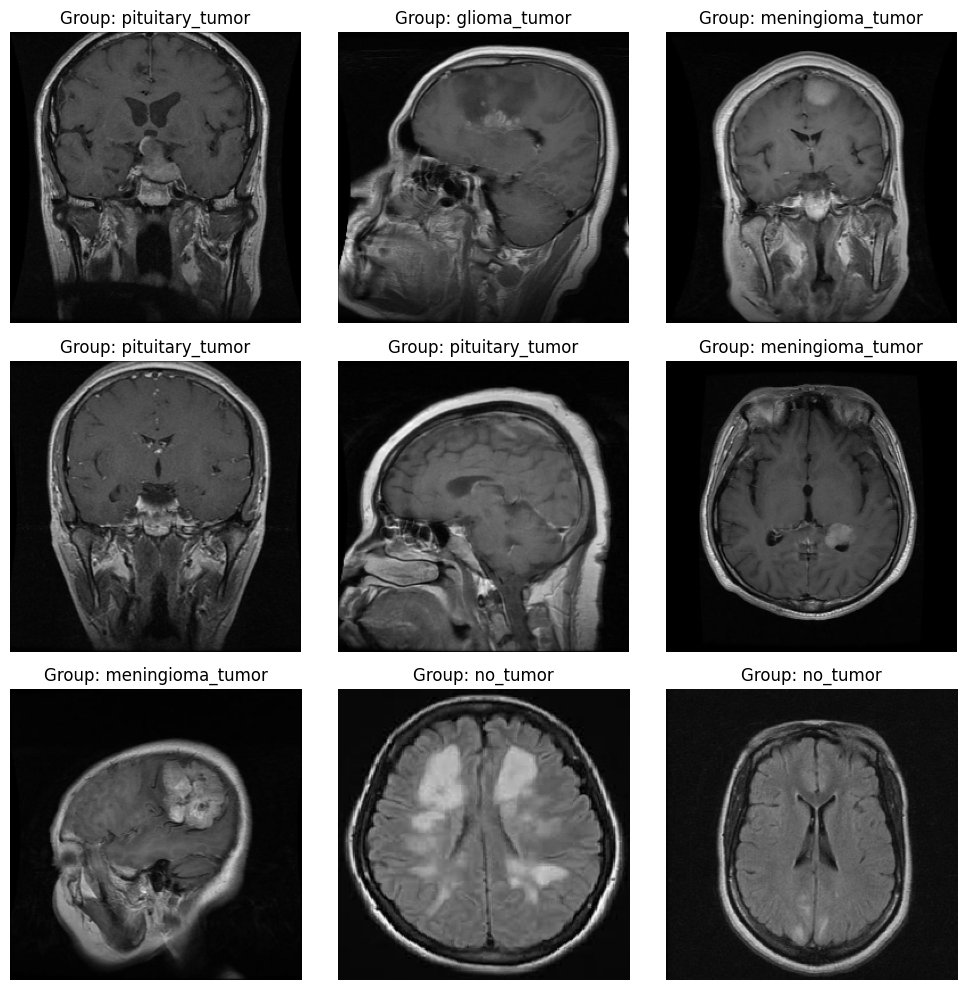

In [4]:
# Function to display 9 random images with labels
print(tf.__version__)
import random
def display_random_images(grouped_images_data):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()  # Flatten the axes array for easier iteration

    # Select 9 random images with their group labels
    random_images = []
    for _ in range(9):
        # Randomly choose a group
        group = random.choice(list(grouped_images_data.keys()))
        # Randomly select an image from the chosen group
        image = random.choice(grouped_images_data[group])
        random_images.append((image, group))

    # Plot the images
    for ax, (image, group) in zip(axes, random_images):
        ax.imshow(image)
        ax.set_title(f"Group: {group}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display images
display_random_images(grouped_images_data)

#### Evaluation Metrics and Acceptence Criteria
Given the objective of this project is to spot the presence of a tumor in brain MRI images, the most important metric to consider is the model's ability to correctly answer the question "Is there a tumor?". This is a binary classification problem where the model should be able to correctly identify the presence of a tumor as true positive and the absence of a tumor as true negative. But since we are working with identification problem, we need to consider the following metrics: false positives where the model incorrectly detecting a tumor when where wasn't and false negatives where the model failing to detect a tumor when it is present. In this case, since the matter of the problem is medical, it is crucial to minimize false negatives as it could have severe consequences, while false positives can be further investigated with human intervention most likely fixing the mistake.

Therefore, the most important metrics to consider are the recall score since our main goal is to minimize false negatives. But just because we want to minimize false negatives doesn't mean we should ignore false positives. We should also consider precision score to minimize false positives as well. One attribute of our dataset is that there is an imbalance in the number of no_tumor to tumor images, with tumor image being the majority. This imbalance could lead to a model that predicts tumor for every image, which would result in a high recall score but a low precision score.

 We can combine these two metrics into a single metric with the F1 score, which is the harmonic mean of precision and recall. This will help us evaluate the model's overall performance in balancing false positives and false negatives.

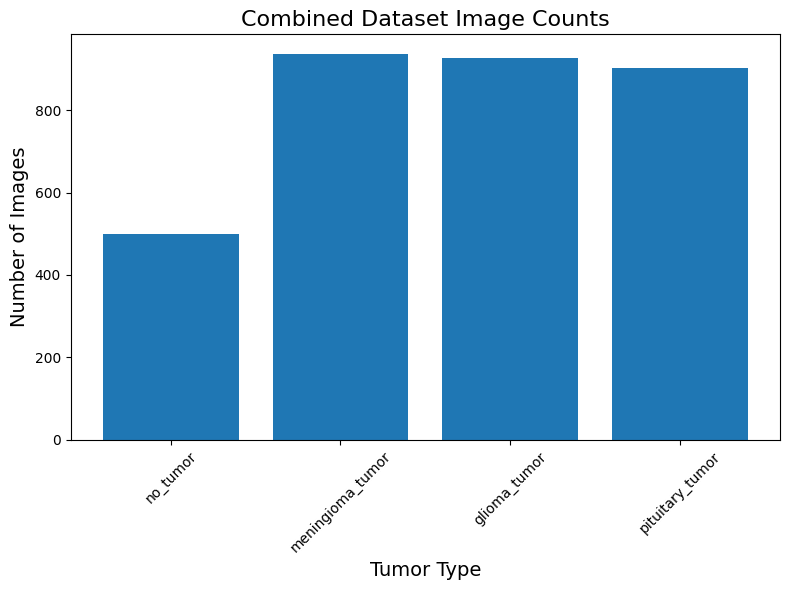

In [5]:
plot_image_counts({group: len(paths) for group, paths in grouped_images.items()}, "Combined Dataset Image Counts")

#### Cross-Validation

Looking at the distribution of images across the different groups, we can see that there is a significant imbalance in the number of images that are no_tumor to tumor. This imbalance can lead to issues when training a machine learning model, especially when using cross-validation. As a result, we will use Stratified 10-Fold Cross-Validation to ensure that each fold has the same proportion of no_tumor to tumor images as the original dataset. The idea is that this will help prevent the model from being biased towards the majority class and provide a more accurate estimate of the model's performance. In the real world scenario, the probability of seeing a tumor is very low, so we need to make sure that our model is able to detect the tumor when it is present and not just detect tumor for every image. On top of that, tumors, just like any other body parts, are unique to every person. You don't want to overfit the model to the training data and have it fail to generalize to new data. This is why we need to balance the classes in each fold of the cross-validation.

In [6]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical

print(tf.__version__)
# Flatten the grouped images and labels for cross-validation
all_images = []
all_labels = []
label_map = {'no_tumor': 0, 'meningioma_tumor': 1, 'glioma_tumor': 2, 'pituitary_tumor': 3}

for group, images in grouped_images_data.items():
    labels = np.full(len(images), label_map[group])  # Assign label for each group
    all_images.append(images)
    all_labels.append(labels)

# Convert all images and labels to numpy arrays
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Normalize images
all_images = all_images / 255.0

# Convert labels to categorical (one-hot encoded)
all_labels = to_categorical(all_labels, num_classes=4)

# Initialize Stratified KFold
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Run Stratified 10-Fold Cross-Validation
fold = 1
for train_index, val_index in kf.split(all_images, np.argmax(all_labels, axis=1)):
    X_train, X_val = all_images[train_index], all_images[val_index]
    y_train, y_val = all_labels[train_index], all_labels[val_index]

    # Here, you would train your model on X_train and evaluate it on X_val
    print(f"Fold {fold}")
    print(f"Train set size: {len(X_train)}, Validation set size: {len(X_val)}")

    fold += 1


2.7.0
Fold 1
Train set size: 2937, Validation set size: 327
Fold 2
Train set size: 2937, Validation set size: 327
Fold 3
Train set size: 2937, Validation set size: 327
Fold 4
Train set size: 2937, Validation set size: 327
Fold 5
Train set size: 2938, Validation set size: 326
Fold 6
Train set size: 2938, Validation set size: 326
Fold 7
Train set size: 2938, Validation set size: 326
Fold 8
Train set size: 2938, Validation set size: 326
Fold 9
Train set size: 2938, Validation set size: 326
Fold 10
Train set size: 2938, Validation set size: 326


### Modeling
#### Data Augmentation
Before we start building our model, we need to consider the size of our dataset. We have a total of 3064 images, which is a relatively small dataset for training a deep learning model. To help prevent overfitting and improve the model's generalization, we can use data augmentation techniques.

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

print(tf.__version__)

# Initialize the Sequential model
model = Sequential()

# Add data augmentation layers
model.add(RandomFlip("horizontal", input_shape=(256, 256, 3)))  # Horizontal flip
model.add(RandomFlip("vertical"))  # Vertical flip
model.add(RandomRotation(0.25))  # Random rotation
model.add(RandomZoom(0.1))  # Random zoom


2.7.0


2024-11-23 15:51:55.821511: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Since our data are all MRI brain scans, there is only a few ways we can augment the data to mimic real life MRI scans.
##### Horizontal Flip
    RandomFlip("horizontal", input_shape=(256, 256, 3)
We can flip the images horizontally to simulate length wise mirroring of the head.

##### Vertical Flip
    RandomFlip("vertical")
We can flip the images vertical to simulate width wise mirroring of the head.

##### Rotation
    RandomRotation(0.25)
We can also rotate the images to simulate different angles of the head. The 0.25 means rotation up to plus-or-minus 25% of a circal or 90 degrees. (+/- 90 degrees)

##### Zoom
    RandomZoom(0.1)
We can zoom in and out to simulate different zoom levels of the MRI scan. The 0.1 means zoom up to 10% of the image size. (+/- 10%)

These are the most common data augmentation techniques used for image data. But do keep in mind that because we are working with MRI scans, we need to be careful with the augmentation techniques we use. We don't want to distort the images too much as it could affect the quality of the scans, causing it to become unrealistic. We want to make sure that the augmented images still look like MRI scans of the brain.